In [1]:
import cloudvolume
import pandas as pd
from imageryclient import ImageryClient
import imageryclient as ic
import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import Image
import fastremap
import os
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
import vtk
import time
from tqdm import tqdm

In [2]:
cb2_em = "precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/em"
img_source = cb2_em
seg_source = "precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/seg"

In [3]:
img_cv = cloudvolume.CloudVolume(cb2_em, mip=0, use_https=True)

In [4]:
print(img_cv.bounds)

Bbox([0, 0, 0],[249600, 230400, 1200], dtype=int32)


In [5]:
img_cv.resolution

Vec(4,4,40, dtype=int32)

In [6]:
# enter a segid or a desired filename for image saving purposes

desc = 'non_purk_mito_'
segid = 3897699205322

In [7]:
imagestacks_dir = 'image_stacks/'+str(desc)+str(segid)+'/' 

In [8]:
imagestacks_dir

'image_stacks/non_purk_mito_3897699205322/'

In [9]:
os.makedirs(imagestacks_dir, exist_ok=True)

# cb2 EM image visualizer 

In [10]:
# set desired image size

image_size = 2048
half_image_size = image_size/2

# enter coordinates from Neuroglancer; make x and y the same, changing only the z-position

bottom_position = [88113, 75523, 100]
top_position = [88113, 75523, 130]

zslices = top_position[2] - bottom_position[2]
mid_slice =  int(zslices/2)
mid_position = [bottom_position[0], bottom_position[1], bottom_position[2]+mid_slice]

print(f'Slices:',zslices)
print(f'Mid slice:', mid_slice)
print(f'Mid position:', mid_position)

position_x = mid_position[0]
position_y = mid_position[1]
position_z = mid_position[2]

position_x_min = int(position_x - half_image_size)
position_x_max = int(position_x + half_image_size)
position_y_min = int(position_y - half_image_size)
position_y_max = int(position_y + half_image_size)
position_z_max = position_z + 1

print(position_x_min, position_x_max)
print(position_y_min, position_y_max)
print(position_z, position_z_max)

Slices: 30
Mid slice: 15
Mid position: [88113, 75523, 115]
87089 89137
74499 76547
115 116


In [11]:
img = img_cv[position_x_min:position_x_max, position_y_min:position_y_max, position_z]

Downloading: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


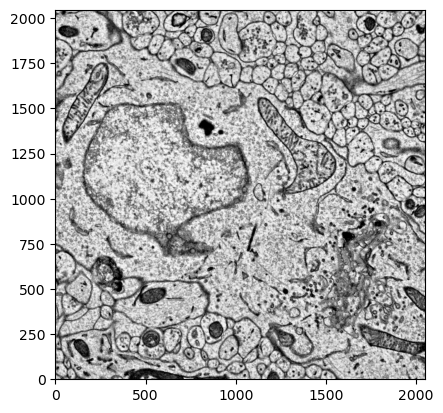

In [12]:
# show image from bottom position
# from: https://stackoverflow.com/questions/31401812/matplotlib-rotate-image-file-by-x-degrees
tr = scipy.ndimage.rotate(img, 90)
plt.imshow(np.squeeze(tr), cmap=plt.cm.gray, origin='lower')

In [13]:
img_client = ic.ImageryClient(image_source=img_source, segmentation_source=seg_source)

## Save single image to disk

In [ ]:
# Save single image to disk; uncomment pil_image.save line

# Convert the numpy array to a PIL image
pil_image = Image.fromarray(image.T)

# Specify the path to the folder and the file name
folder_path = imagestacks_dir
file_name = str(desc) + str(segid) + '_' + str(position_z) + '.png'
file_path = f"{folder_path}/{file_name}"

# Save the image
# pil_image.save(file_path)

print(f"Image saved to {file_path}")


## Generate and save a z-stack of images

In [ ]:
# Loop through the zslices with a progress bar
for i in tqdm(range(zslices), desc="Generating Images"):
    # Generate EM image, starting at the bottom z-position
    img_width = image_size
    z_iter = [bottom_position[0], bottom_position[1], bottom_position[2] + i]
    
    # Assuming img_client and ic are already defined and properly set up
    image = img_client.image_cutout(z_iter, bbox_size=(img_width, img_width))
    bounds = ic.bounds_from_center(z_iter, width=img_width, height=img_width, depth=1)
    image = img_client.image_cutout(bounds)
    
    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image.T)
    
    # Specify the path to the folder and the file name
    folder_path = imagestacks_dir
    file_name = f"{desc}{segid}_{bottom_position[2] + i}.png"
    file_path = f"{folder_path}/{file_name}"
    
    # Save the image
    pil_image.save(file_path)
    
    print(f"Image saved to {file_path}")


In [ ]:
# The code in the previous cell can hang; uncomment and run the following to pick up where you left off

# # Define the range for the remaining z values
# start_z = 10
# end_z = 30

# # Loop through the remaining zslices with a progress bar
# for i in tqdm(range(start_z, end_z + 1), desc="Generating Images"):
#     # Generate EM image, starting at the bottom z-position
#     img_width = image_size
#     z_iter = [bottom_position[0], bottom_position[1], bottom_position[2] + i]
    
#     # Assuming img_client and ic are already defined and properly set up
#     image = img_client.image_cutout(z_iter, bbox_size=(img_width, img_width))
#     bounds = ic.bounds_from_center(z_iter, width=img_width, height=img_width, depth=1)
#     image = img_client.image_cutout(bounds)
    
#     # Convert the numpy array to a PIL image
#     pil_image = Image.fromarray(image.T)
    
#     # Specify the path to the folder and the file name
#     folder_path = imagestacks_dir
#     file_name = f"{desc}{segid}_{bottom_position[2] + i}.png"
#     file_path = f"{folder_path}/{file_name}"
    
#     # Save the image
#     pil_image.save(file_path)
    
#     print(f"Image saved to {file_path}")
